# HW2 - Indexing & Document Retrieval

In [1]:
# import
from IPython.display import display, Markdown, Latex
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np
from os import listdir
from os.path import isfile, join
import csv
import matplotlib.pyplot as plt

## Load data and some helpful methods

In [2]:
# Get data from files and return list
def load_data_from_files(path, range_size, suffix):
    tmp = []
    for d in range(range_size):
        f = open(path+str(d+1)+"."+suffix)
        tmp.append(f.read())
    return tmp

In [3]:
# set contants
data_file_path = "../data/d/"
query_file_path = "../data/q/"
reference_file_path = "../data/r/"
n_documents = 1400
n_query = 225

In [4]:
# load data to lists
data = load_data_from_files(data_file_path, n_documents, "txt")
query = load_data_from_files(query_file_path, n_query, "txt")
# append it for can vectorize to same size of vector and computing tf-idf
for i in query:
    data.append(i)
# load references for query to list of set.
# they not have same size, set is fast for find the same.
ref = [{int(j) for j in i.split()} for i in load_data_from_files(reference_file_path, 225, "txt")]

In [5]:
# compute similarity for query vector
# return top_n relevant documents, similarities for relevant and not sorted similarities
def get_top_n_relevant(query_vector, data, n, metric, ascent = True):
    sim = np.array(metric(query_vector, data)[0])
    if ascent: return sim.argsort()[:n]+1, sorted(sim)[:n], sim
    return sim.argsort()[-n:][::-1]+1, sorted(sim)[-n:][::-1], sim

## Create representation with the vector model with four different weightings

In [6]:
# create model of data and query for tf-idf
tfidf_data_matrix = TfidfVectorizer(analyzer = 'word', stop_words = 'english').fit_transform(data)
tfidf_query_matrix = tfidf_data_matrix[len(data)-len(query):]
tfidf_data_matrix = tfidf_data_matrix[:len(data)-len(query)]

In [7]:
# create model of data and query on pure raw count of terms 
rc_data_matrix = CountVectorizer(analyzer = 'word', stop_words = 'english').fit_transform(data).astype(np.double)
rc_query_matrix = rc_data_matrix[len(data)-len(query):]
rc_data_matrix = rc_data_matrix[:len(data)-len(query)]

In [8]:
# create model of data with term frequency
tf_data_matrix = CountVectorizer(analyzer = 'word', stop_words = 'english').fit_transform(data).astype(np.double)
for i, j in enumerate(data):
    tf_data_matrix[i] = tf_data_matrix[i]/tf_data_matrix[i].sum() if tf_data_matrix[i].sum() > 0 else tf_data_matrix[i]
tf_query_matrix = tf_data_matrix[len(data)-len(query):]
tf_data_matrix = tf_data_matrix[:len(data)-len(query)]

In [9]:
# create binary model only replace raw count by 1 in sparse matrix representation of matrix
binary_data_matrix = CountVectorizer(analyzer = 'word', stop_words = 'english').fit_transform(data)
# so replece with same matrix with ones
binary_data_matrix.data = np.ones(shape=binary_data_matrix.data.shape, dtype=binary_data_matrix.data.dtype)
binary_query_matrix = binary_data_matrix[len(data)-len(query):]
binary_data_matrix = binary_data_matrix[:len(data)-len(query)]

## Write cosine similarity and Euclidean distance to files for each weighing

In [10]:
# method for write computed in file, 
# get to n relevant return as third parameter similarity in order of documents and returl all fon n = 0
def write_data_to_csv(file_name, matrix_with_queries, matrix_with_data, similarity_meansure):
    with open(file_name, 'w') as myfile:
        wr = csv.writer(myfile)
        wr.writerow(['QID'] + [str(i+1) for i in range(n_documents)])
        for i in range(n_query):
            wr.writerow(np.insert(get_top_n_relevant(matrix_with_queries[i], 
                                                     matrix_with_data, 
                                                     0, 
                                                     similarity_meansure)[2], 0, i+1, axis=0))

In [11]:
# write to csv files
write_data_to_csv("../results/tfidf_cosineS.csv", tfidf_query_matrix, tfidf_data_matrix, cosine_similarity)
write_data_to_csv("../results/tfidf_euclidD.csv", tfidf_query_matrix, tfidf_data_matrix, euclidean_distances)

write_data_to_csv("../results/rc_cosineS.csv", rc_query_matrix, rc_data_matrix, cosine_similarity)
write_data_to_csv("../results/rc_euclidD.csv", rc_query_matrix, rc_data_matrix, euclidean_distances)

write_data_to_csv("../results/tf_cosineS.csv", tf_query_matrix, tf_data_matrix, cosine_similarity)
write_data_to_csv("../results/tf_euclidD.csv", tf_query_matrix, tf_data_matrix, euclidean_distances)

write_data_to_csv("../results/binary_cosineS.csv", binary_query_matrix, binary_data_matrix, cosine_similarity)
write_data_to_csv("../results/binary_euclidD.csv", binary_query_matrix, binary_data_matrix, euclidean_distances)

## Evaluate some metric such as precision, recall, and F-measure.

In [12]:
# method for computing the confusion matrix for top-n relevant
def compute_confusion_matrix(predic_as_relevant, relevant, total_count):
    tp = 0
    fp = 0
    fn = 0
    tn = 0
    for i in predic_as_relevant:
        if i in relevant:
            tp +=1
    fn = len(relevant)-tp
    fp = len(predic_as_relevant)-tp
    tn = total_count - fn - fp - tp
    return tp, fp, fn, tn

In [13]:
def recall(tp, fp, fn, tn):
    return tp/(tp+fn)

In [14]:
def precision(tp, fp, fn, tn):
    return tp/(tp+fp)

In [15]:
def F1meansure(tp, fp, fn, tn):
    return (2*tp)/(2*tp+fp+fn)

In [16]:
# function for measure one n and metric on all queries and relevancy
def meansure_it(data_query, n_query, query_relevant, data, metric_name, n, documents_count):
    if metric_name == 'cosineS':
        metric_name = cosine_similarity
        a=False
    elif metric_name == 'euclidD':
        metric_name = euclidean_distances
        a=True
    else:
        print("metric error")
        return
    rec = 0
    prec = 0
    f1 = 0
    for i in range(n_query):
        if n == 0:
            n = len(query_relevant[i])
        relevant = get_top_n_relevant(data_query[i], data, n, metric_name, a)[0]
        con = compute_confusion_matrix(relevant, query_relevant[i], documents_count)
        rec += recall(*con)
        prec += precision(*con)
        f1 += F1meansure(*con)
    return rec/n_query, prec/n_query, f1/n_query


In [17]:
# Meansure all metric with all weithing model and print average values
# Get it for top-n which is the count of relevant in reference, 
# because I don't know the threshold and the static n can do some bias if relevant is less than n or vice versa
display(Markdown('### tf-idf and euclidean distance'))
print("Average recall: %s\nAverage precision: %s\nAverage F-meansure: %s" % 
      meansure_it(tfidf_query_matrix, n_query, ref, tfidf_data_matrix, 'euclidD', 0, n_documents))
display(Markdown('### tf-idf and cosine similarity'))
print("Average recall: %s\nAverage precision: %s\nAverage F-meansure: %s" % 
      meansure_it(tfidf_query_matrix, n_query, ref, tfidf_data_matrix, 'cosineS', 0, n_documents))

display(Markdown('### <span style="color:green"> tf and euclidean distance</span>'))
print("Average recall: %s\nAverage precision: %s\nAverage F-meansure: %s" % 
      meansure_it(tf_query_matrix, n_query, ref, tf_data_matrix, 'euclidD', 0, n_documents))
display(Markdown('### <span style="color:green"> tf and cosine similarity</span>'))
print("Average recall: %s\nAverage precision: %s\nAverage F-meansure: %s" % 
      meansure_it(tf_query_matrix, n_query, ref, tf_data_matrix, 'cosineS', 0, n_documents))

display(Markdown('### raw count of terms and euclidean distance'))
print("Average recall: %s\nAverage precision: %s\nAverage F-meansure: %s" % 
      meansure_it(rc_query_matrix, n_query, ref, rc_data_matrix, 'euclidD', 0, n_documents))
display(Markdown('### raw count of terms and cosine similarity'))
print("Average recall: %s\nAverage precision: %s\nAverage F-meansure: %s" % 
      meansure_it(rc_query_matrix, n_query, ref, rc_data_matrix, 'cosineS', 0, n_documents))

display(Markdown('### <span style="color:green"> binary representation and euclidean distance</span>'))
print("Average recall: %s\nAverage precision: %s\nAverage F-meansure: %s" % 
      meansure_it(binary_query_matrix, n_query, ref, binary_data_matrix, 'euclidD', 0, n_documents))
display(Markdown('### <span style="color:green"> binary representation and cosine similarity</span>'))
print("Average recall: %s\nAverage precision: %s\nAverage F-meansure: %s" % 
      meansure_it(binary_query_matrix, n_query, ref, binary_data_matrix, 'cosineS', 0, n_documents))


### tf-idf and euclidean distance

Average recall: 0.49879757943258907
Average precision: 0.12475095785440622
Average F-meansure: 0.18959857704755778


### tf-idf and cosine similarity

Average recall: 0.5065055813072575
Average precision: 0.1265900383141763
Average F-meansure: 0.19248219777713485


### <span style="color:green"> tf and euclidean distance</span>

Average recall: 0.3579317800635903
Average precision: 0.09241379310344836
Average F-meansure: 0.13942847089217847


### <span style="color:green"> tf and cosine similarity</span>

Average recall: 0.44647888863288687
Average precision: 0.1121839080459771
Average F-meansure: 0.17029899219588607


### raw count of terms and euclidean distance

Average recall: 0.04004874648552809
Average precision: 0.009501915708812264
Average F-meansure: 0.014438151004604029


### raw count of terms and cosine similarity

Average recall: 0.44499740715140534
Average precision: 0.11203065134099625
Average F-meansure: 0.17002121441810827


### <span style="color:green"> binary representation and euclidean distance</span>

Average recall: 0.04727056787401613
Average precision: 0.011647509578544057
Average F-meansure: 0.01776157682613699


### <span style="color:green"> binary representation and cosine similarity</span>

Average recall: 0.4550348499555149
Average precision: 0.11157088122605374
Average F-meansure: 0.17061639258335246


In [18]:
data = []
for i in range(7):
    data.append([])
for i in range(1, n_documents, 10):
    data[6].append(i)
    rec, prec, f = meansure_it(tfidf_query_matrix, n_query, ref, tfidf_data_matrix, 'euclidD', i, n_documents)
    data[0].append(rec)
    data[1].append(prec)
    data[2].append(f)
    rec, prec, f = meansure_it(tfidf_query_matrix, n_query, ref, tfidf_data_matrix, 'cosineS', i, n_documents)
    data[3].append(rec)
    data[4].append(prec)
    data[5].append(f)

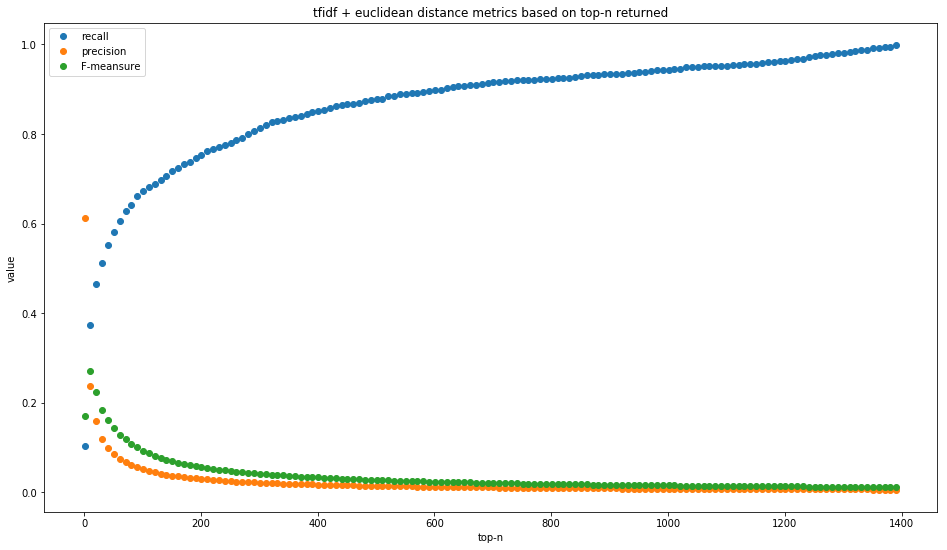

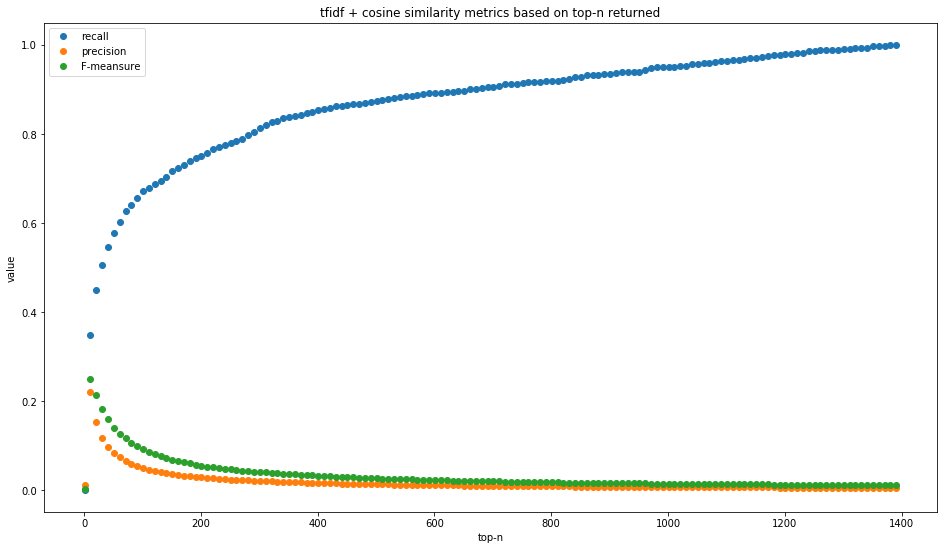

In [19]:
plt.rcParams["figure.figsize"] = [16,9]
plt.title('tfidf + euclidean distance metrics based on top-n returned')
plt.plot(data[6], data[3], 'o', 
         data[6], data[4], 'o',
         data[6], data[5], 'o')
plt.xlabel('top-n')
plt.ylabel('value')
plt.legend(['recall', 'precision', 'F-meansure'])
plt.show()
plt.title('tfidf + cosine similarity metrics based on top-n returned')
plt.plot(data[6], data[0], 'o', 
         data[6], data[1], 'o', 
         data[6], data[2], 'o',)
plt.xlabel('top-n')
plt.legend(['recall', 'precision', 'F-meansure'])
plt.ylabel('value')
plt.show()
